# Homework 5: Part I

1. Go get data from kaggle.com and do a ***Bayesian Linear Regression*** analysis

```python
import pymc as pm; import numpy as np
n,p=100,10; X,y=np.zeros((n,p)),np.ones((n,1))
# Replace this made up data with your data set from kaggle...
with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros((p,1)), cov=np.eye(p), shape=(p,1))
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0) # half normal
    y = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma, observed=y)

with MLR:
    idata = pm.sample()
```    

2. Choose ***prior*** that are sensible: certainly you might change the ***hyperparameters***, and perhaps you can experiment with different distributional families for `sigma`...

3. [Optional] Assess the performance of the MCMC and note any issues or warnings

    1. Traceplots, inference (credible) intervals, effective sample sizes, energy plots, warnings and other notes... just the usual stuff they do [here](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#pymc-overview)

4. [Optional] Perform ***Multiple Linear Regression*** diagnostics... residual plots, etc.


In [1]:
import pymc as pm
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import arviz as az

In [2]:
df = pd.read_csv("kaggledata.csv")
df["Grade High"] = pd.to_numeric(df["Grade High"], errors='coerce')
df["Average Math Proficiency"] = pd.to_numeric(df["Average Math Proficiency"], errors='coerce')
df["Average ELA Proficiency"] = pd.to_numeric(df["Average ELA Proficiency"], errors='coerce')
df1 = df[["Average ELA Proficiency", "Average Math Proficiency", "Grade High"]]
df1.fillna(df1.mean(), inplace=True)
df1

/tmp/ipykernel_52/1283811819.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.fillna(df1.mean(), inplace=True)


,Average ELA Proficiency,Average Math Proficiency,Grade High
0,2.14,2.17,5.0
1,2.63,2.98,5.0
2,2.39,2.54,5.0
3,2.48,2.47,8.0
4,2.38,2.54,5.0
...,...,...,...
1267,2.48,2.60,5.0
1268,2.50,2.85,8.0
1269,2.77,3.09,8.0
1270,2.60,3.29,5.0


In [41]:
p = 3
X = df1[["Grade High", "Average Math Proficiency"]]
X.insert(0, 'intercept', 1)
observed_y = df1["Average ELA Proficiency"]

with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros(p), cov=np.eye(p), shape=p)
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0) # half normal
    y = pm.Normal('y', mu=pm.math.dot(X.values, betas), sigma=sigma, observed=observed_y)

with MLR:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


# Homework 5: Part II
    
## Answer the following with respect to $p(\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y})$ on the previous slide
    
1. Rewrite $p(\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y})$ in terms of $\sigma^2$ (no longer using $\Sigma$) if $\Sigma=\sigma^2I$

2. What is $E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}]$?

3. What ***hyperparameters*** values (legal or illegal) would make $E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = (\mathbf{X^\top X})^{-1}\mathbf{X^\top y}$?

4. What ***hyperparameters*** values (legal or illegal) would make $E[  \mathbf{\hat y} = \mathbf{X}\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = \mathbf{X}(\mathbf{X^\top X})^{-1}\mathbf{X^\top y}$?

5. What is $\text{Var}[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}]$?

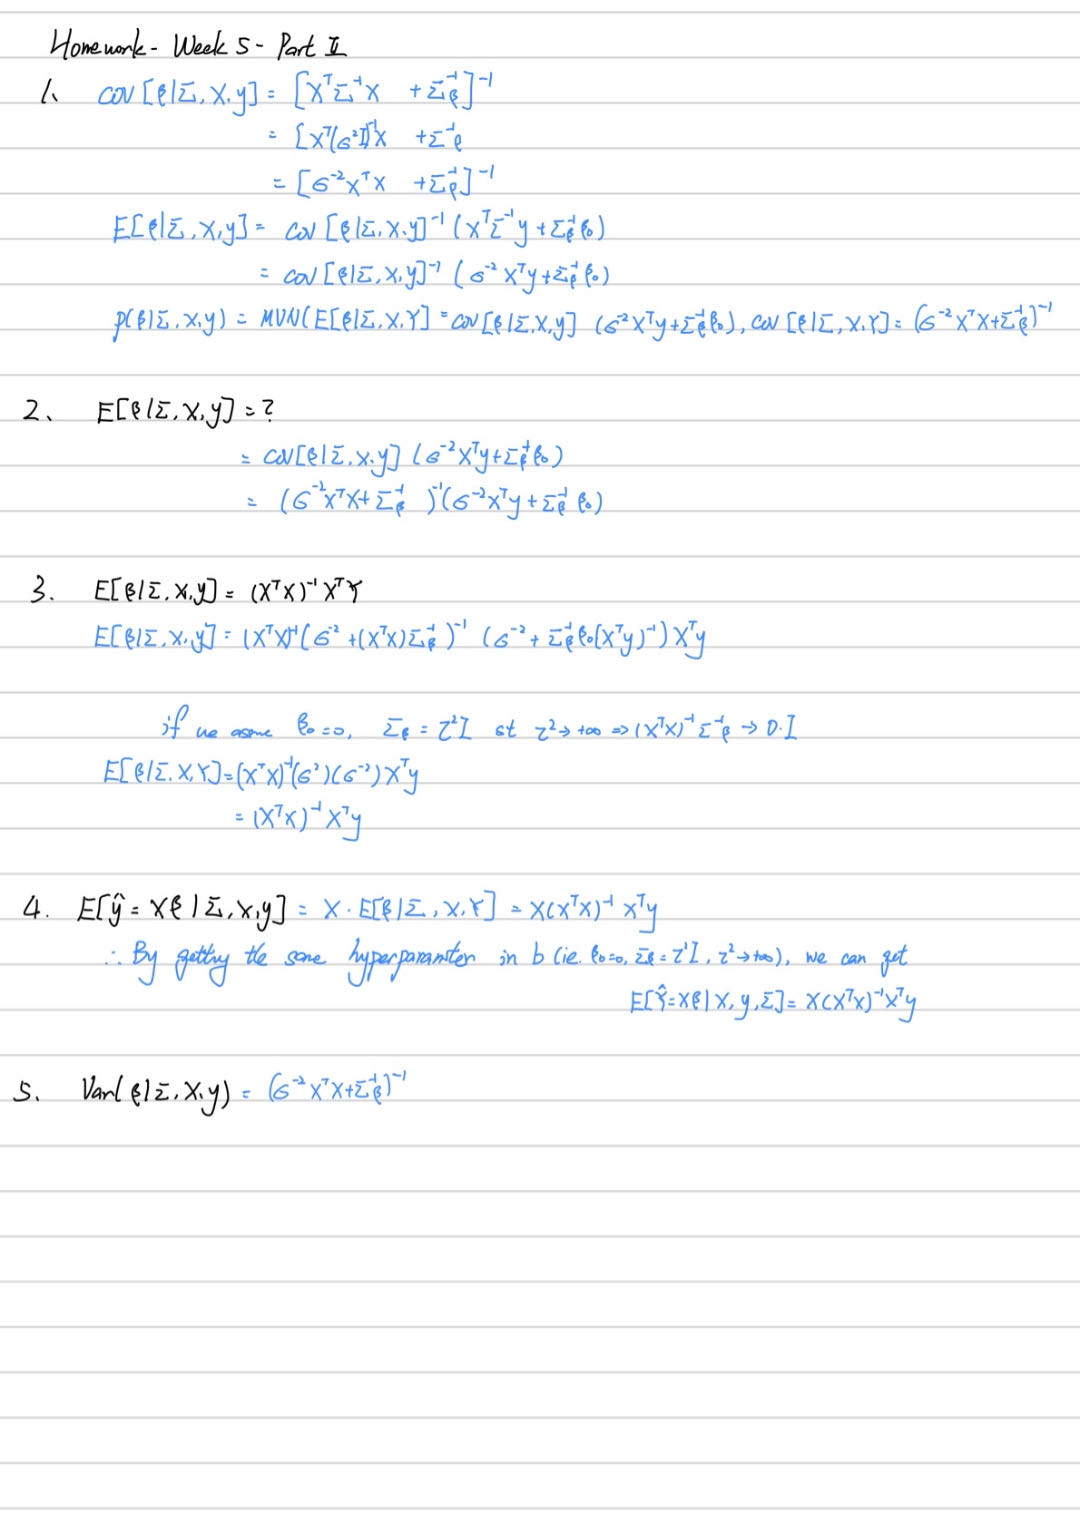

# Homework 5: Part III

1. Go get data from kaggle.com and perform inference for a ***Bayesian Multivariate Normal Model***

<SPAN STYLE="font-size:18.0pt">

```python
import numpy as np; from scipy import stats
p=10; Psi=np.eye(p); a_cov = stats.invwishart(df=p+2, scale=Psi).rvs(1)
n=1000; y=stats.multivariate_normal(mean=np.zeros(p), cov=a_cov).rvs(size=n)
# Replace this made up data with your data set from kaggle...
    
with pm.Model() as MNV_LKJ:
    packed_L = pm.LKJCholeskyCov("packed_L", n=p, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=2), compute_corr=False)
    L = pm.expand_packed_triangular(p, packed_L)
    # Sigma = pm.Deterministic('Sigma', L.dot(L.T)) # Don't use a covariance matrix parameterization
    mu = pm.MvNormal('mu', mu=np.array(0), cov=np.eye(p), shape=p); 
    # y = pm.MvNormal('y', mu=mu, cov=Sigma, shape=(n,1), observed=y) 
    # Figure out how to parameterize this with a Cholesky factor to improve computational efficiency 
with MNV_LKJ    
    idata = pm.sample()
```    
</SPAN>

2. As indicated above, don't use a covariance matrix parameterization and instead figure out how to parameterize this with a ***Cholesky factor*** to improve computational efficiency. The ***Cholesky***-based formulation allows general $O(n^3)$ $\det({\boldsymbol \Sigma})$ to be computed using a simple $O(n)$ product and general $O(n^3)$ ${\boldsymbol \Sigma}^{-1}$ to be instead evaluated with $O(n^2)$ ***backward substitution***. 

2. Specify ***priors*** that work: certainly you'll likely need to change the ***prior hyperparameters*** for $\boldsymbol \mu$ (`mu`) and $\mathbf{R}$ (`packed_L`)...
    1. And you could consider adjusting the ***prior*** for $\boldsymbol \sigma$ using `sd_dist`... 

3. [Optional] Assess the performance of the MCMC and note any issues

    1. Traceplots, inference (credible) intervals, effective sample sizes, energy plots, warnings and other notes... just the usual stuff they do [here](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#pymc-overview)



In [31]:
y = df1["Average ELA Proficiency"].values.reshape(-1, 1)  # Assuming "Average ELA Proficiency" is a column in your DataFrame


In [69]:
p= 2
n = 1000
    
with pm.Model() as MNV_LKJ:
    packed_L = pm.LKJCholeskyCov("packed_L", n=p, eta=2.0,
                                 sd_dist=pm.Gamma.dist(alpha=2, beta=2, shape=2), compute_corr=False)
    L = pm.expand_packed_triangular(p, packed_L)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T)) 
    mu = pm.StudentT('mu', nu=3, mu=0, sigma=1, shape=p)
    new_y = pm.MvNormal('y', mu=mu, cov=Sigma, shape=(n,1), observed=y) 
    
with MNV_LKJ:   
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, mu]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2448 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1026 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
